# Project 6 – BI Insights and Storytelling
### Kevin Hennelly

---

## 1. Business Goal
Analyze how customer email opt-in status affects sales performance and product/category engagement across regions, stores, and order value.

---

## 2. Data Source
- smart_sales.dw
- Tables: customers, sales, products, dates, stores, campaigns

---

## 3. Tools
- PySpark
- Pandas
- Seaborn / Matplotlib

---

## 4. Workflow (Slice, Dice, Drilldown)
- Slicing: total sales by email opt-in
- Dicing: sales by region and email opt-in
- Dicing: sales by product category and email opt-in
- Dicing: total sales by product category and email opt-in
- Slicing: distribution of order values by email opt-in
- Dicing: sales by region and product category 
- Dicing: sales by product category and email opt-in
- Dicing: sales by region and email opt-in
- Drilldown: email opt-in > product category
- Drilldown: email opt in > lat purchase month

In [1]:
#needed imports
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import matplotlib.ticker as mtick

# Reusable currency formatter for y-axes
def currency_format(x, pos):
    if x >= 1_000_000:
        return f'${x/1_000_000:.2f}M'
    elif x >= 1_000:
        return f'${x/1_000:.0f}K'
    else:
        return f'${x:.0f}'

currency_formatter = mtick.FuncFormatter(currency_format)

In [3]:
# Chart look
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

from pyspark.sql import SparkSession

# Chart look
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

# Use the SAME absolute JAR path that works in Project 5
jdbc_jar = "/Users/kevinhennelly/Repos/smart-store-kevinhennelly/data/lib/sqlite_jdbc-3.51.0.0.jar"

spark = (
    SparkSession.builder
    .appName("SmartSalesDW_P6")
    .config("spark.jars", jdbc_jar)
    .config("spark.driver.extraClassPath", jdbc_jar)
    .config("spark.executor.extraClassPath", jdbc_jar)
    .getOrCreate()
)

spark

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
25/11/16 19:23:15 WARN Utils: Your hostname, Kevins-MacBook-Pro.local, resolves to a loopback address: 127.0.0.1; using 10.40.16.9 instead (on interface en0)
25/11/16 19:23:15 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
25/11/16 19:23:15 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [5]:
# Absolute path to smart_sales.dw file
dw_path = "/Users/kevinhennelly/Repos/smart-store-kevinhennelly/data/dw/smart_sales.dw"

url = f"jdbc:sqlite:{dw_path}"
driver = "org.sqlite.JDBC"

print("URL:", url)

URL: jdbc:sqlite:/Users/kevinhennelly/Repos/smart-store-kevinhennelly/data/dw/smart_sales.dw


In [6]:
# Customers
customers = (
    spark.read.format("jdbc")
    .option("url", url)
    .option("dbtable", "customers")
    .option("driver", driver)
    .load()
)
customers.createOrReplaceTempView("customers")

# Sales
sales = (
    spark.read.format("jdbc")
    .option("url", url)
    .option("dbtable", "sales")
    .option("driver", driver)
    .load()
)
sales.createOrReplaceTempView("sales")

# Products
products = (
    spark.read.format("jdbc")
    .option("url", url)
    .option("dbtable", "products")
    .option("driver", driver)
    .load()
)
products.createOrReplaceTempView("products")

# Dates
dates = (
    spark.read.format("jdbc")
    .option("url", url)
    .option("dbtable", "dates")
    .option("driver", driver)
    .load()
)
dates.createOrReplaceTempView("dates")

# Stores
stores = (
    spark.read.format("jdbc")
    .option("url", url)
    .option("dbtable", "stores")
    .option("driver", driver)
    .load()
)
stores.createOrReplaceTempView("stores")

# Campaigns
campaigns = (
    spark.read.format("jdbc")
    .option("url", url)
    .option("dbtable", "campaigns")
    .option("driver", driver)
    .load()
)
campaigns.createOrReplaceTempView("campaigns")

In [7]:
#verification of data loading
spark.sql("SELECT * FROM customers LIMIT 5").show()
spark.sql("SELECT * FROM sales LIMIT 5").show()
spark.sql("SELECT * FROM products LIMIT 5").show()
spark.sql("SELECT * FROM dates LIMIT 5").show()
spark.sql("SELECT * FROM stores LIMIT 5").show()
spark.sql("SELECT * FROM campaigns LIMIT 5").show()

+-----------+-------------+-------+----------+------------------+------------+
|customer_id|         name| region| join_date|last_purchase_date|email_opt_in|
+-----------+-------------+-------+----------+------------------+------------+
|       1000| Robert Gomez|   west|2024-02-25|        2025-10-14|           0|
|       1001|   John Silva|   east|2020-12-01|        2021-11-26|           0|
|       1002|Mark Marshall|central|2020-08-08|        2024-10-06|           1|
|       1003|David Brennan|  north|2020-05-21|        2023-06-14|           1|
|       1004|Kerry Collins|  north|2023-09-12|        2024-09-04|           0|
+-----------+-------------+-------+----------+------------------+------------+

+-------+----------+-----------+----------+--------+-----------+-----------------+--------+------------+
|sale_id|      date|customer_id|product_id|store_id|campaign_id|payment_method_id|quantity|sales_amount|
+-------+----------+-----------+----------+--------+-----------+--------------

+------------+-----------+----------------+
|email_opt_in|total_sales|unique_customers|
+------------+-----------+----------------+
|          No| 1099571.36|             109|
|         Yes|  926953.77|              92|
+------------+-----------+----------------+



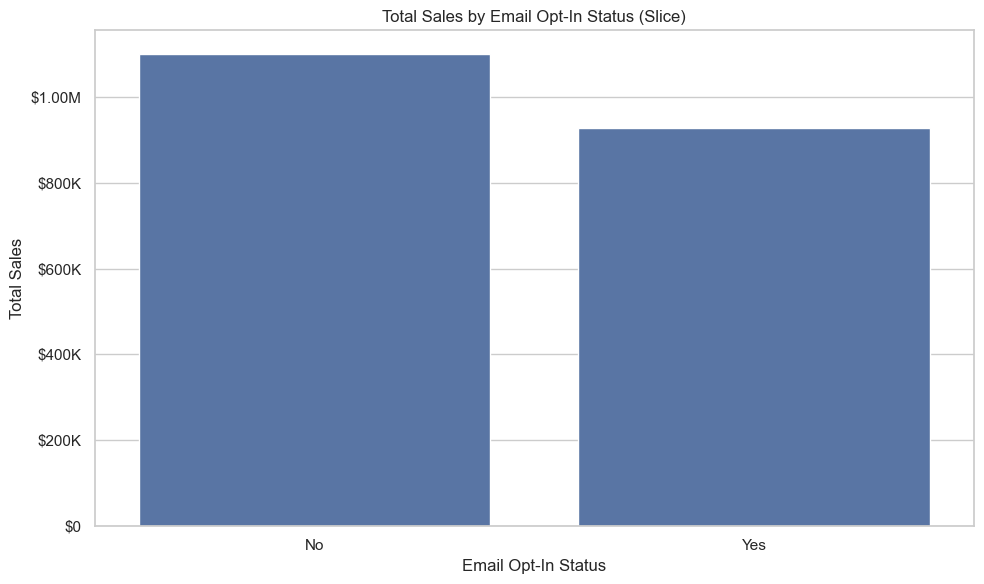

In [8]:
# SLICE: Total sales by email opt-in status (Yes/No) + bar chart

df_optin_sales = spark.sql("""
    SELECT
        CASE
            WHEN c.email_opt_in = 1 THEN 'Yes'
            WHEN c.email_opt_in = 0 THEN 'No'
            ELSE 'Unknown'
        END AS email_opt_in,
        ROUND(SUM(CAST(s.sales_amount AS DECIMAL(12,2))), 2) AS total_sales,
        COUNT(DISTINCT s.customer_id) AS unique_customers
    FROM sales s
    JOIN customers c
        ON s.customer_id = c.customer_id
    GROUP BY c.email_opt_in
    ORDER BY email_opt_in
""")

df_optin_sales.show()

pdf_slice = df_optin_sales.toPandas()

plt.figure()
ax = sns.barplot(
    data=pdf_slice,
    x="email_opt_in",
    y="total_sales"
)

ax.yaxis.set_major_formatter(currency_formatter)

plt.title("Total Sales by Email Opt-In Status (Slice)")
plt.xlabel("Email Opt-In Status")
plt.ylabel("Total Sales")
plt.tight_layout()
plt.show()

+----------+------------+-----------+
|    region|email_opt_in|total_sales|
+----------+------------+-----------+
|          |          No|     288.11|
|   central|          No|   79762.92|
|   central|         Yes|  117587.91|
|      east|          No|  341081.59|
|      east|         Yes|  338619.19|
|     north|          No|  262317.40|
|     north|         Yes|  123974.38|
|     south|          No|  165471.12|
|     south|         Yes|   44287.84|
|south-west|          No|   94250.56|
|south-west|         Yes|  113368.96|
|      west|          No|  156399.66|
|      west|         Yes|  189115.49|
+----------+------------+-----------+



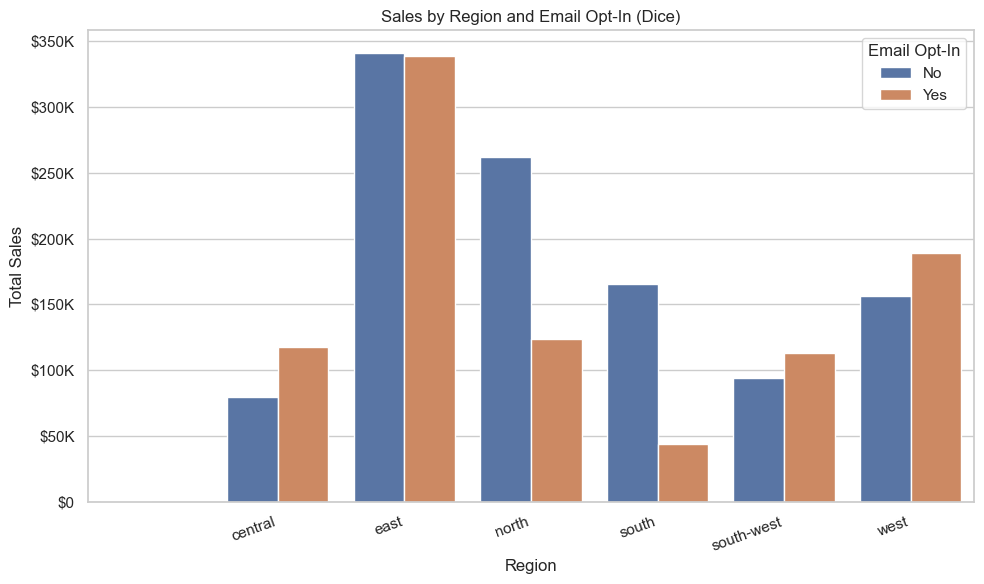

In [9]:
# DICE: Sales by region and email opt-in + grouped bar chart

df_region_optin = spark.sql("""
    SELECT
        c.region,
        CASE
            WHEN c.email_opt_in = 1 THEN 'Yes'
            WHEN c.email_opt_in = 0 THEN 'No'
            ELSE 'Unknown'
        END AS email_opt_in,
        ROUND(SUM(CAST(s.sales_amount AS DECIMAL(12,2))), 2) AS total_sales
    FROM sales s
    JOIN customers c
        ON s.customer_id = c.customer_id
    GROUP BY c.region, c.email_opt_in
    ORDER BY c.region, email_opt_in
""")

df_region_optin.show()

df_region_optin_pd = df_region_optin.toPandas()

plt.figure()
ax = sns.barplot(
    data=df_region_optin_pd,
    x="region",
    y="total_sales",
    hue="email_opt_in"
)

ax.yaxis.set_major_formatter(currency_formatter)

plt.title("Sales by Region and Email Opt-In (Dice)")
plt.xlabel("Region")
plt.ylabel("Total Sales")
plt.xticks(rotation=20, ha="right")
plt.legend(title="Email Opt-In")
plt.tight_layout()
plt.show()

+-----------+------------+-----------+
|   category|email_opt_in|total_sales|
+-----------+------------+-----------+
|   Clothing|          No|  265246.33|
|   Clothing|         Yes|  214941.68|
|Electronics|          No|  275892.46|
|Electronics|         Yes|  228829.85|
|       Home|          No|  316833.09|
|       Home|         Yes|  264527.49|
|     Office|          No|  241599.48|
|     Office|         Yes|  218654.75|
+-----------+------------+-----------+



<Figure size 1000x600 with 0 Axes>

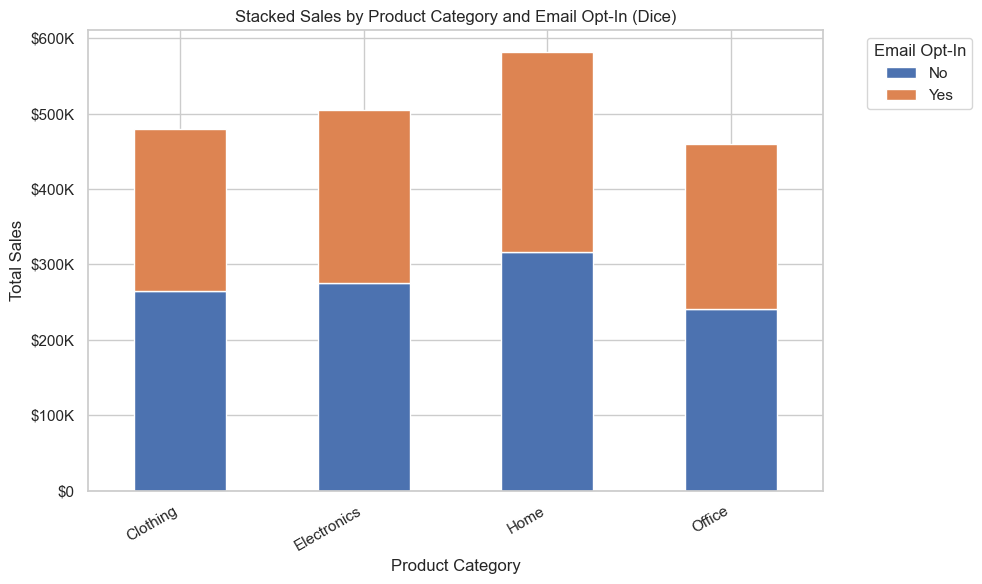

In [10]:
# DICE: Sales by product category and email opt-in + stacked bar chart

df_category_optin = spark.sql("""
    SELECT
        p.category,
        CASE
            WHEN c.email_opt_in = 1 THEN 'Yes'
            WHEN c.email_opt_in = 0 THEN 'No'
            ELSE 'Unknown'
        END AS email_opt_in,
        ROUND(SUM(CAST(s.sales_amount AS DECIMAL(12,2))), 2) AS total_sales
    FROM sales s
    JOIN products p
        ON s.product_id = p.product_id
    JOIN customers c
        ON s.customer_id = c.customer_id
    GROUP BY p.category, c.email_opt_in
    ORDER BY p.category, email_opt_in
""")

df_category_optin.show()

# Convert to Pandas
df_category_optin_pd = df_category_optin.toPandas()

# Ensure numeric type so Pandas can plot it
df_category_optin_pd["total_sales"] = df_category_optin_pd["total_sales"].astype(float)

# Pivot for stacked bar
pivot_cat_optin = df_category_optin_pd.pivot_table(
    index="category",
    columns="email_opt_in",
    values="total_sales",
    aggfunc="sum"
)

# Plot stacked bar
plt.figure()
ax = pivot_cat_optin.plot(
    kind="bar",
    stacked=True,
    figsize=(10, 6)
)

ax.yaxis.set_major_formatter(currency_formatter)

plt.title("Stacked Sales by Product Category and Email Opt-In (Dice)")
plt.xlabel("Product Category")
plt.ylabel("Total Sales")
plt.xticks(rotation=30, ha="right")
plt.legend(title="Email Opt-In", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

+-----------+------------+-----------+
|   category|email_opt_in|total_sales|
+-----------+------------+-----------+
|Electronics|         Yes|  228829.85|
|       Home|         Yes|  264527.49|
|   Clothing|         Yes|  214941.68|
|       Home|          No|  316833.09|
|     Office|          No|  241599.48|
|     Office|         Yes|  218654.75|
|Electronics|          No|  275892.46|
|   Clothing|          No|  265246.33|
+-----------+------------+-----------+



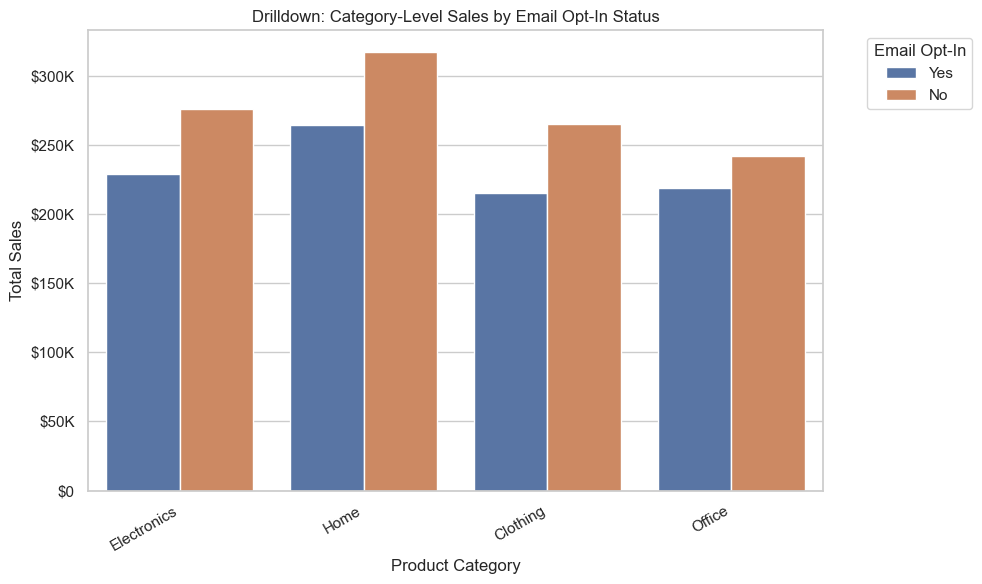

In [11]:
# DRILLDOWN: Total sales by product category and email opt-in (clean labels)

df_category_optin = spark.sql("""
    SELECT
        p.category,
        CASE
            WHEN c.email_opt_in = 1 THEN 'Yes'
            WHEN c.email_opt_in = 0 THEN 'No'
            ELSE 'Unknown'
        END AS email_opt_in,
        ROUND(SUM(CAST(s.sales_amount AS DECIMAL(12,2))), 2) AS total_sales
    FROM sales s
    JOIN products p
        ON s.product_id = p.product_id
    JOIN customers c
        ON s.customer_id = c.customer_id
    GROUP BY p.category, c.email_opt_in
""")

df_category_optin.show()

# Convert to pandas
df_category_optin_pd = df_category_optin.toPandas()
df_category_optin_pd["total_sales"] = df_category_optin_pd["total_sales"].astype(float)

plt.figure(figsize=(10, 6))
ax = sns.barplot(
    data=df_category_optin_pd,
    x="category",
    y="total_sales",
    hue="email_opt_in",
)

ax.yaxis.set_major_formatter(currency_formatter)

plt.title("Drilldown: Category-Level Sales by Email Opt-In Status")
plt.xlabel("Product Category")
plt.ylabel("Total Sales")
plt.xticks(rotation=30, ha="right")
plt.legend(title="Email Opt-In", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

+------------+-----------+
|email_opt_in|order_value|
+------------+-----------+
|          No|        0.0|
|          No|     1066.8|
|          No|     413.78|
|          No|     561.83|
|          No|     698.25|
+------------+-----------+
only showing top 5 rows


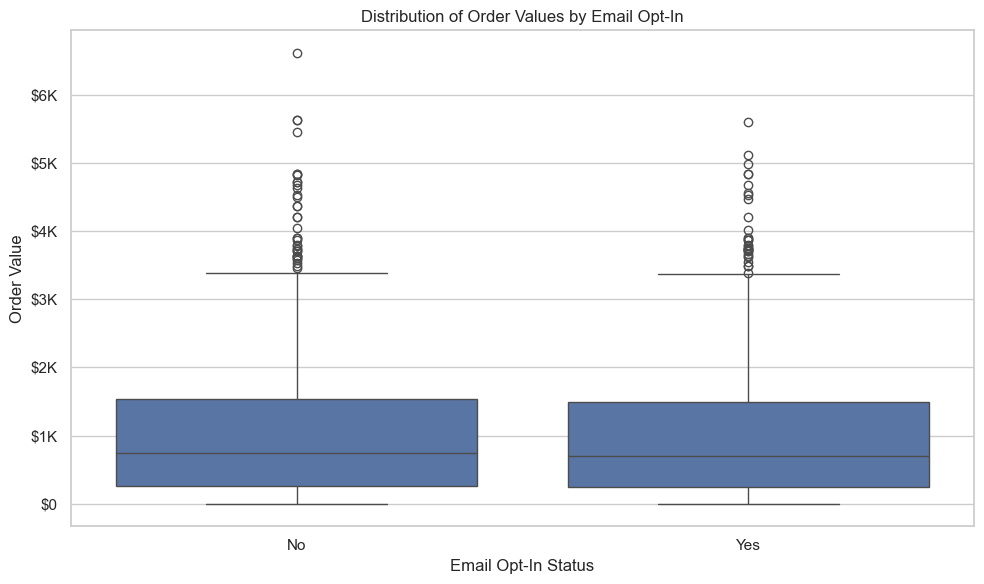

In [12]:
# Box plot: Distribution of order values by email opt-in

df_order_values = spark.sql("""
    SELECT
        CASE
            WHEN c.email_opt_in = 1 THEN 'Yes'
            WHEN c.email_opt_in = 0 THEN 'No'
            ELSE 'Unknown'
        END AS email_opt_in,
        CAST(s.sales_amount AS DOUBLE) AS order_value
    FROM sales s
    JOIN customers c
        ON s.customer_id = c.customer_id
""")

df_order_values.show(5)

df_order_values_pd = df_order_values.toPandas()

plt.figure()
ax = sns.boxplot(
    data=df_order_values_pd,
    x="email_opt_in",
    y="order_value"
)

ax.yaxis.set_major_formatter(currency_formatter)

plt.title("Distribution of Order Values by Email Opt-In")
plt.xlabel("Email Opt-In Status")
plt.ylabel("Order Value")
plt.tight_layout()
plt.show()

+----------+-----------+-----------+
|    region|   category|total_sales|
+----------+-----------+-----------+
|          |Electronics|     288.11|
|   central|   Clothing|   50431.97|
|   central|Electronics|   46391.76|
|   central|       Home|   45117.29|
|   central|     Office|   55409.81|
|      east|   Clothing|  165987.00|
|      east|Electronics|  192588.34|
|      east|       Home|  201646.95|
|      east|     Office|  119478.49|
|     north|   Clothing|   85830.15|
|     north|Electronics|  101109.14|
|     north|       Home|  108436.18|
|     north|     Office|   90916.31|
|     south|   Clothing|   65946.97|
|     south|Electronics|   40253.30|
|     south|       Home|   51765.59|
|     south|     Office|   51793.10|
|south-west|   Clothing|   36216.18|
|south-west|Electronics|   41478.74|
|south-west|       Home|   64920.65|
+----------+-----------+-----------+
only showing top 20 rows


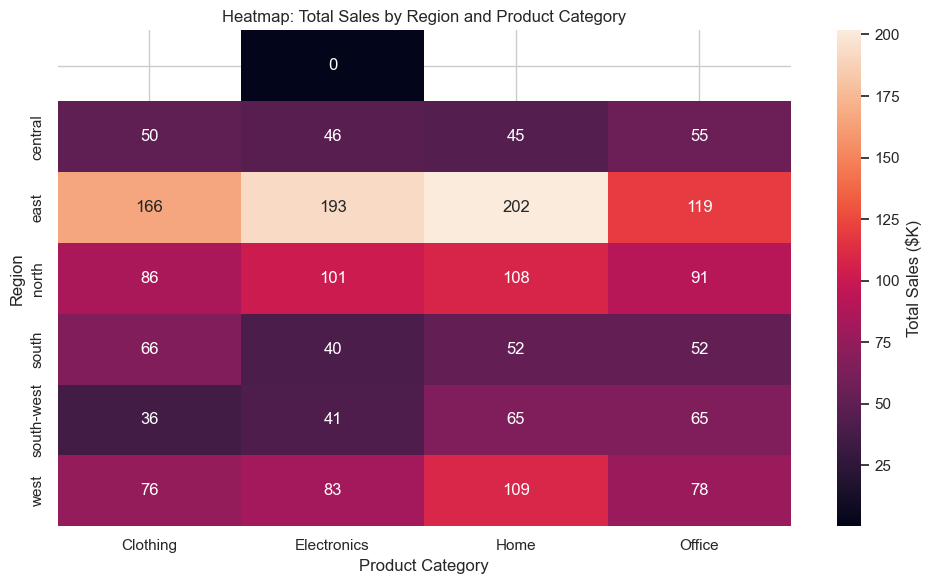

In [13]:
# HEATMAP A: Total sales by region and product category

df_region_category = spark.sql("""
    SELECT
        c.region,
        p.category,
        ROUND(SUM(CAST(s.sales_amount AS DECIMAL(12,2))), 2) AS total_sales
    FROM sales s
    JOIN customers c
        ON s.customer_id = c.customer_id
    JOIN products p
        ON s.product_id = p.product_id
    GROUP BY c.region, p.category
    ORDER BY c.region, p.category
""")

df_region_category.show()

# ---- Convert to pandas + ensure numeric ----
df_region_category_pd = df_region_category.toPandas()
df_region_category_pd["total_sales"] = df_region_category_pd["total_sales"].astype(float)

# Pivot for heatmap
pivot_region_cat = df_region_category_pd.pivot_table(
    index="region",
    columns="category",
    values="total_sales",
    aggfunc="sum"
)

# Show in thousands for nicer scale
pivot_region_cat_k = pivot_region_cat / 1_000.0

plt.figure(figsize=(10, 6))
ax = sns.heatmap(
    pivot_region_cat_k,
    annot=True,
    fmt=".0f"      # integer thousands
)

# Colorbar label
cbar = ax.collections[0].colorbar
cbar.set_label("Total Sales ($K)")

plt.title("Heatmap: Total Sales by Region and Product Category")
plt.xlabel("Product Category")
plt.ylabel("Region")
plt.tight_layout()
plt.show()

+-----------+------------+-----------+
|   category|email_opt_in|total_sales|
+-----------+------------+-----------+
|   Clothing|          No|  265246.33|
|   Clothing|         Yes|  214941.68|
|Electronics|          No|  275892.46|
|Electronics|         Yes|  228829.85|
|       Home|          No|  316833.09|
|       Home|         Yes|  264527.49|
|     Office|          No|  241599.48|
|     Office|         Yes|  218654.75|
+-----------+------------+-----------+



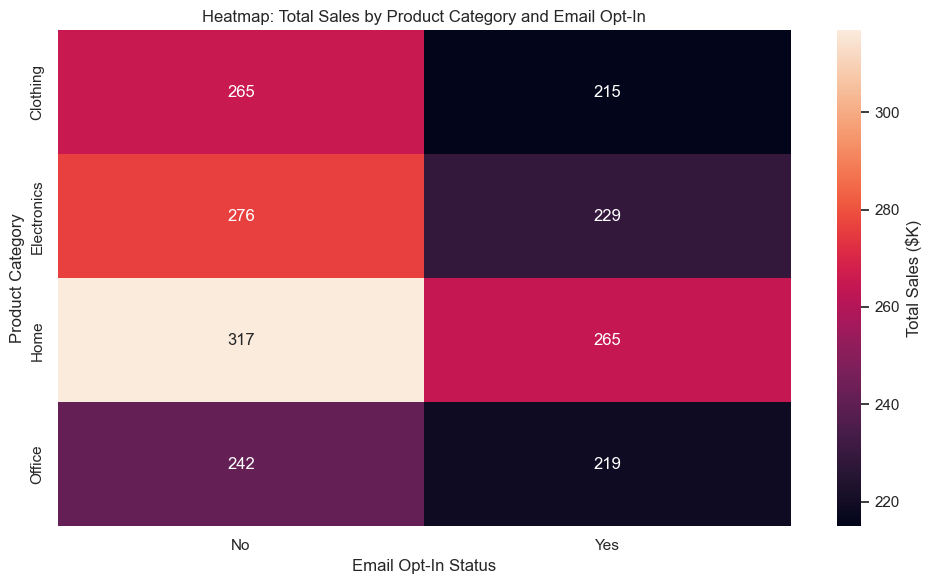

In [14]:
# HEATMAP B: Sales by Product Category and Email Opt-In

df_cat_optin = spark.sql("""
    SELECT
        p.category,
        CASE
            WHEN c.email_opt_in = 1 THEN 'Yes'
            WHEN c.email_opt_in = 0 THEN 'No'
            ELSE 'Unknown'
        END AS email_opt_in,
        ROUND(SUM(CAST(s.sales_amount AS DECIMAL(12,2))), 2) AS total_sales
    FROM sales s
    JOIN customers c
        ON s.customer_id = c.customer_id
    JOIN products p
        ON s.product_id = p.product_id
    GROUP BY p.category, c.email_opt_in
    ORDER BY p.category, email_opt_in
""")

df_cat_optin.show()

# ---- Convert to pandas + enforce numeric ----
df_cat_optin_pd = df_cat_optin.toPandas()
df_cat_optin_pd["total_sales"] = df_cat_optin_pd["total_sales"].astype(float)

# Pivot for heatmap
pivot_cat_optin = df_cat_optin_pd.pivot_table(
    index="category",
    columns="email_opt_in",
    values="total_sales",
    aggfunc="sum"
)

# Convert to thousands
pivot_cat_optin_k = pivot_cat_optin / 1_000.0

plt.figure(figsize=(10, 6))
ax = sns.heatmap(
    pivot_cat_optin_k,
    annot=True,
    fmt=".0f"  # whole thousands
)

# Colorbar formatting
cbar = ax.collections[0].colorbar
cbar.set_label("Total Sales ($K)")

plt.title("Heatmap: Total Sales by Product Category and Email Opt-In")
plt.xlabel("Email Opt-In Status")
plt.ylabel("Product Category")
plt.tight_layout()
plt.show()

+----------+------------+-----------+
|    region|email_opt_in|total_sales|
+----------+------------+-----------+
|          |          No|     288.11|
|   central|          No|   79762.92|
|   central|         Yes|  117587.91|
|      east|          No|  341081.59|
|      east|         Yes|  338619.19|
|     north|          No|  262317.40|
|     north|         Yes|  123974.38|
|     south|          No|  165471.12|
|     south|         Yes|   44287.84|
|south-west|          No|   94250.56|
|south-west|         Yes|  113368.96|
|      west|          No|  156399.66|
|      west|         Yes|  189115.49|
+----------+------------+-----------+



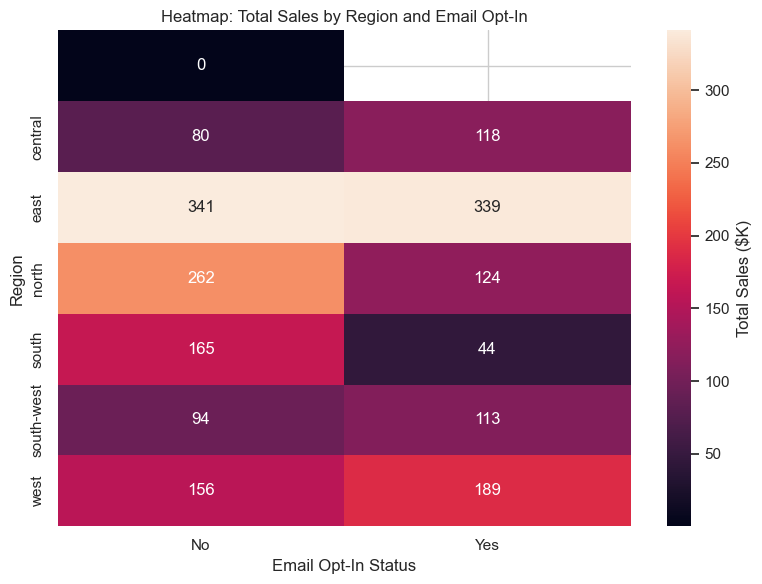

In [15]:
# HEATMAP C: Total Sales by Region and Email Opt-In

df_region_optin = spark.sql("""
    SELECT
        c.region,
        CASE
            WHEN c.email_opt_in = 1 THEN 'Yes'
            WHEN c.email_opt_in = 0 THEN 'No'
            ELSE 'Unknown'
        END AS email_opt_in,
        ROUND(SUM(CAST(s.sales_amount AS DECIMAL(12,2))), 2) AS total_sales
    FROM sales s
    JOIN customers c
        ON s.customer_id = c.customer_id
    GROUP BY c.region, c.email_opt_in
    ORDER BY c.region, email_opt_in
""")

df_region_optin.show()

# Convert to pandas + ensure numeric
df_region_optin_pd = df_region_optin.toPandas()
df_region_optin_pd["total_sales"] = df_region_optin_pd["total_sales"].astype(float)

# Pivot for heatmap
pivot_region_optin = df_region_optin_pd.pivot_table(
    index="region",
    columns="email_opt_in",
    values="total_sales",
    aggfunc="sum"
)

# Show in thousands
pivot_region_optin_k = pivot_region_optin / 1_000.0

plt.figure(figsize=(8, 6))
ax = sns.heatmap(
    pivot_region_optin_k,
    annot=True,
    fmt=".0f"  # whole thousands
)

# Colorbar label
cbar = ax.collections[0].colorbar
cbar.set_label("Total Sales ($K)")

plt.title("Heatmap: Total Sales by Region and Email Opt-In")
plt.xlabel("Email Opt-In Status")
plt.ylabel("Region")
plt.tight_layout()
plt.show()

+------------+-----------+
|email_opt_in|total_sales|
+------------+-----------+
|          No| 1099571.36|
|         Yes|  926953.77|
+------------+-----------+



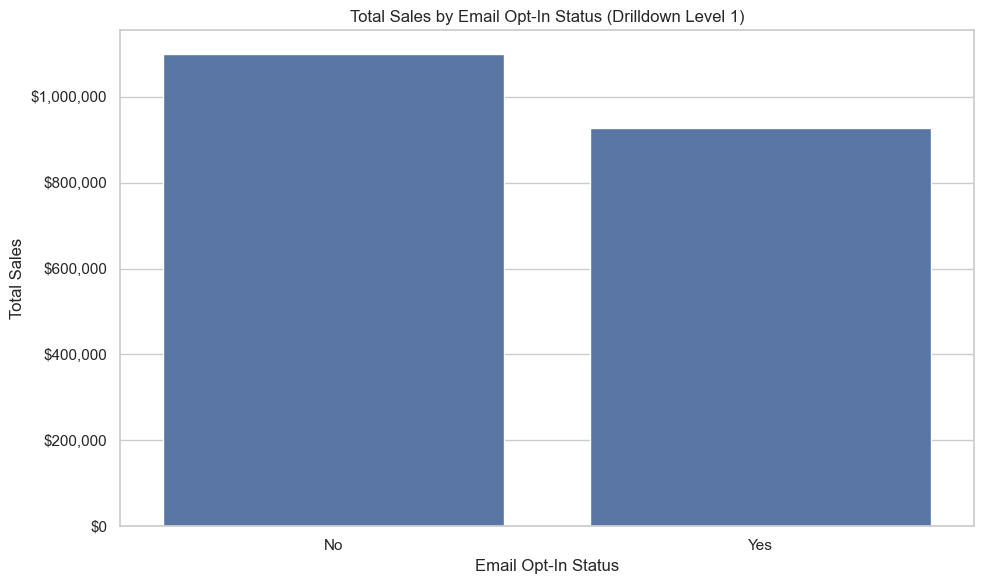

+------------+-----------+-----------+
|email_opt_in|   category|total_sales|
+------------+-----------+-----------+
|          No|   Clothing|  265246.33|
|          No|Electronics|  275892.46|
|          No|       Home|  316833.09|
|          No|     Office|  241599.48|
|         Yes|   Clothing|  214941.68|
|         Yes|Electronics|  228829.85|
|         Yes|       Home|  264527.49|
|         Yes|     Office|  218654.75|
+------------+-----------+-----------+



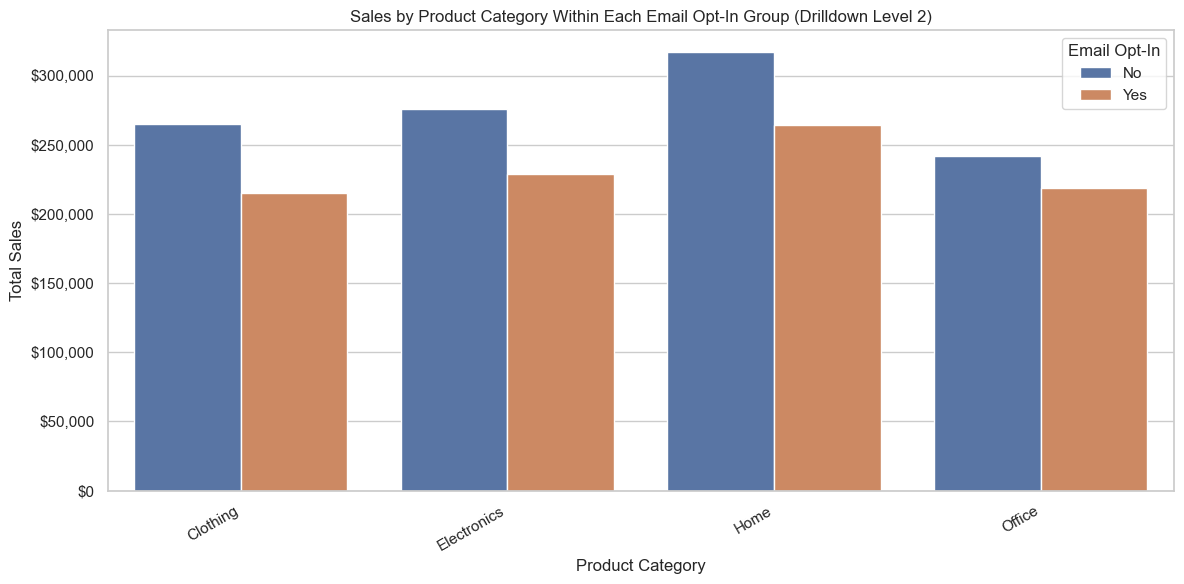

In [16]:
# DRILLDOWN: Email Opt-In → Product Category
# Level 1: Total sales by email opt-in
# Level 2: Sales by product category within each opt-in group

# Local currency formatter for this cell
currency_formatter = plt.FuncFormatter(lambda x, pos: f'${x:,.0f}')

# -------------------------------
# DRILLDOWN LEVEL 1: Email Opt-In
# -------------------------------
df_optin = spark.sql("""
    SELECT
        CASE
            WHEN c.email_opt_in = 1 THEN 'Yes'
            WHEN c.email_opt_in = 0 THEN 'No'
            ELSE 'Unknown'
        END AS email_opt_in,
        ROUND(SUM(CAST(s.sales_amount AS DECIMAL(12,2))), 2) AS total_sales
    FROM sales s
    JOIN customers c ON s.customer_id = c.customer_id
    GROUP BY email_opt_in
    ORDER BY email_opt_in
""")

df_optin.show()

df_optin_pd = df_optin.toPandas()
df_optin_pd["total_sales"] = df_optin_pd["total_sales"].astype(float)

plt.figure(figsize=(10, 6))
ax = sns.barplot(data=df_optin_pd, x="email_opt_in", y="total_sales")

ax.yaxis.set_major_formatter(currency_formatter)
plt.title("Total Sales by Email Opt-In Status (Drilldown Level 1)")
plt.xlabel("Email Opt-In Status")
plt.ylabel("Total Sales")
plt.tight_layout()
plt.show()

# -----------------------------------------------
# DRILLDOWN LEVEL 2: Email Opt-In → Product Category
# -----------------------------------------------
df_optin_category = spark.sql("""
    SELECT
        CASE
            WHEN c.email_opt_in = 1 THEN 'Yes'
            WHEN c.email_opt_in = 0 THEN 'No'
            ELSE 'Unknown'
        END AS email_opt_in,
        p.category,
        ROUND(SUM(CAST(s.sales_amount AS DECIMAL(12,2))), 2) AS total_sales
    FROM sales s
    JOIN customers c ON s.customer_id = c.customer_id
    JOIN products p ON s.product_id = p.product_id
    GROUP BY email_opt_in, p.category
    ORDER BY email_opt_in, p.category
""")

df_optin_category.show()

df_optin_category_pd = df_optin_category.toPandas()
df_optin_category_pd["total_sales"] = df_optin_category_pd["total_sales"].astype(float)

plt.figure(figsize=(12, 6))
ax = sns.barplot(
    data=df_optin_category_pd,
    x="category",
    y="total_sales",
    hue="email_opt_in"
)

ax.yaxis.set_major_formatter(currency_formatter)
plt.title("Sales by Product Category Within Each Email Opt-In Group (Drilldown Level 2)")
plt.xlabel("Product Category")
plt.ylabel("Total Sales")
plt.legend(title="Email Opt-In")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()

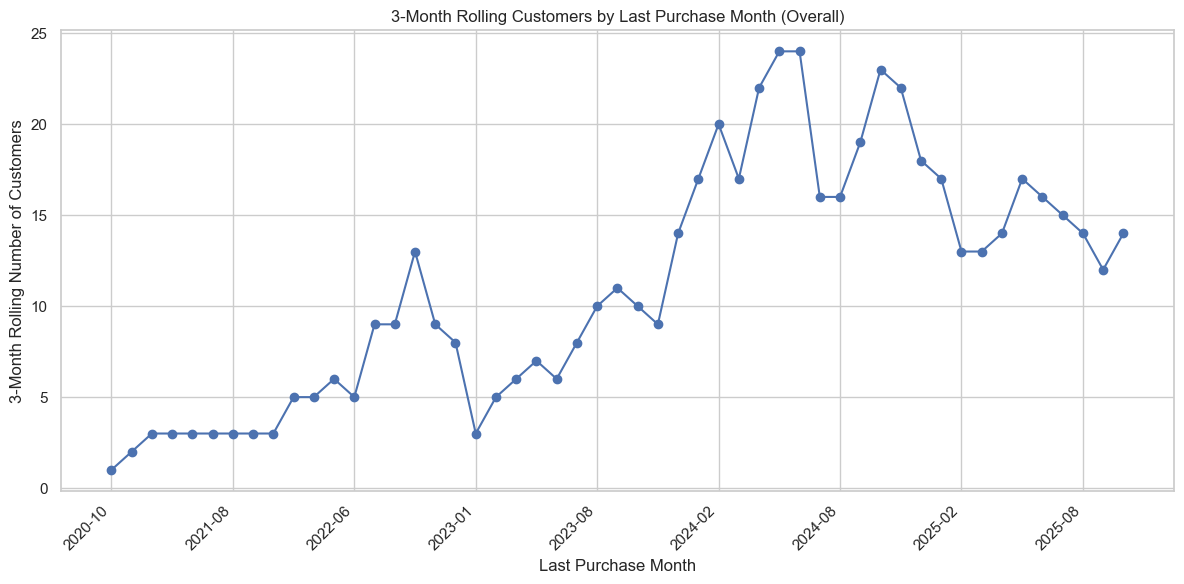

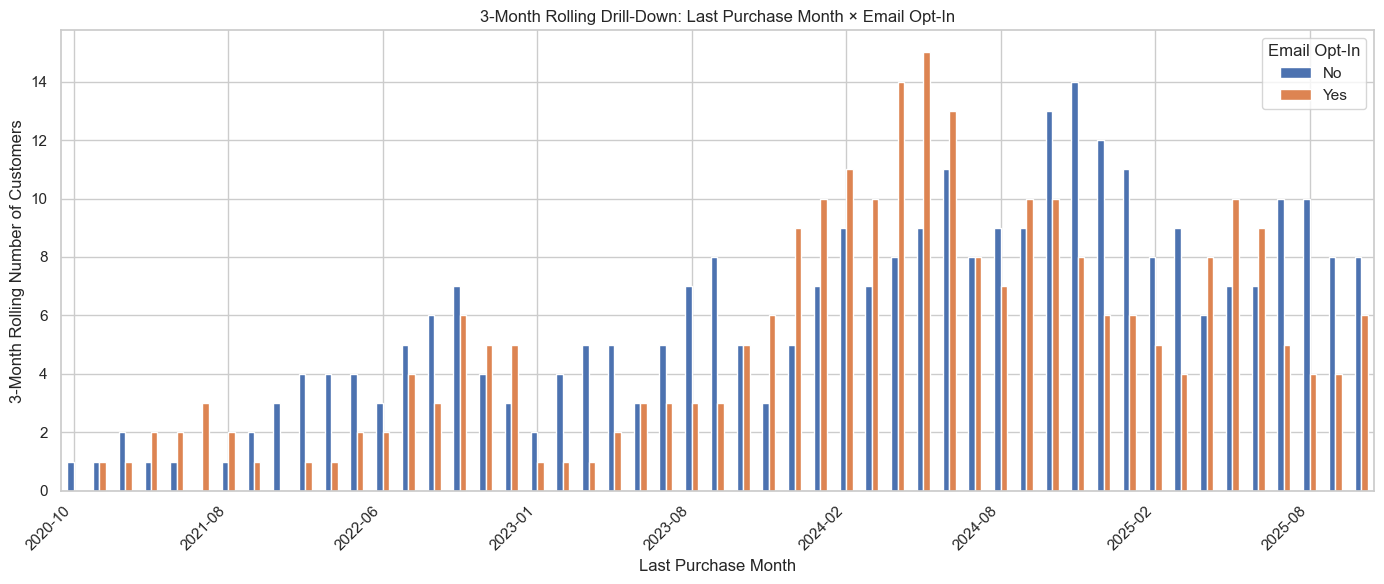

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.sql.functions import substring, col, countDistinct, when

# -----------------------------------------------------
# 1. Load CUSTOMERS table
# -----------------------------------------------------
customers_df = spark.sql("""
    SELECT customer_id, last_purchase_date, email_opt_in
    FROM customers
""")

# -----------------------------------------------------
# 2. Create Year-Month string (YYYY-MM)
# -----------------------------------------------------
customers_df = customers_df.withColumn(
    "last_purchase_ym",
    substring(col("last_purchase_date"), 1, 7)
)

# Drop empty or invalid months
customers_df = customers_df.filter(col("last_purchase_ym") != "")

# -----------------------------------------------------
# 3. Convert email_opt_in (0/1) → "No" / "Yes"
# -----------------------------------------------------
customers_df = customers_df.withColumn(
    "email_opt_in_label",
    when(col("email_opt_in") == 1, "Yes").otherwise("No")
)

# -----------------------------------------------------
# 4. HIGH-LEVEL MONTHLY TREND
# -----------------------------------------------------
monthly_df = (
    customers_df
    .groupBy("last_purchase_ym")
    .agg(countDistinct("customer_id").alias("num_customers"))
    .orderBy("last_purchase_ym")
)

monthly_pdf = monthly_df.toPandas()

# Convert YYYY-MM → datetime safely
monthly_pdf["date"] = pd.to_datetime(monthly_pdf["last_purchase_ym"] + "-01")

# Sort
monthly_pdf = monthly_pdf.sort_values("date")

# 3-month rolling total
monthly_pdf["num_customers_3m"] = (
    monthly_pdf["num_customers"]
    .rolling(window=3, min_periods=1)
    .sum()
)

# -----------------------------------------------------
# 5. DRILL-DOWN: Month × Email Opt-In ("Yes"/"No")
# -----------------------------------------------------
drill_df = (
    customers_df
    .groupBy("last_purchase_ym", "email_opt_in_label")
    .agg(countDistinct("customer_id").alias("num_customers"))
    .orderBy("last_purchase_ym")
)

drill_pdf = drill_df.toPandas()

# Pivot: rows = month, columns = Yes/No
pivot = drill_pdf.pivot(
    index="last_purchase_ym",
    columns="email_opt_in_label",
    values="num_customers"
).fillna(0)

# Convert index to datetime for rolling
pivot.index = pd.to_datetime(pivot.index + "-01")
pivot = pivot.sort_index()

# 3-month rolling sum
pivot_3m = pivot.rolling(window=3, min_periods=1).sum()

# Convert back to YYYY-MM
pivot_3m.index = pivot_3m.index.to_period("M").astype(str)

# -----------------------------------------------------
# 6. VISUAL 1 — 3-Month Rolling Trend
# -----------------------------------------------------
plt.figure(figsize=(12,6))
plt.plot(
    monthly_pdf["date"].dt.strftime("%Y-%m"),
    monthly_pdf["num_customers_3m"],
    marker="o"
)

# Clean x-axis: show every 6th month
positions = range(0, len(monthly_pdf.index), 6)
plt.xticks(
    ticks=positions,
    labels=monthly_pdf["date"].dt.strftime("%Y-%m").iloc[::6],
    rotation=45,
    ha="right"
)

plt.title("3-Month Rolling Customers by Last Purchase Month (Overall)")
plt.xlabel("Last Purchase Month")
plt.ylabel("3-Month Rolling Number of Customers")
plt.tight_layout()
plt.show()

# -----------------------------------------------------
# 7. VISUAL 2 — 3-Month Rolling Drill-Down ("Yes" vs "No")
# -----------------------------------------------------
plt.figure(figsize=(14,6))
pivot_3m.plot(kind="bar", ax=plt.gca())

# Clean x-axis labels
positions = range(0, len(pivot_3m.index), 6)
plt.xticks(
    ticks=positions,
    labels=pivot_3m.index[::6],
    rotation=45,
    ha="right"
)

plt.title("3-Month Rolling Drill-Down: Last Purchase Month × Email Opt-In")
plt.xlabel("Last Purchase Month")
plt.ylabel("3-Month Rolling Number of Customers")
plt.legend(title="Email Opt-In")
plt.tight_layout()
plt.show()

# 5. Results

The OLAP analysis examined customer behavior across email opt-in status, regions, product categories, order values, and time. Slicing, dicing, and drilldown operations revealed consistent patterns in how different customer groups contribute to sales.  Most interesting is that customers that did not opt-in to email marketing were generally larger drivers of sales and revenue than those who did.  This is counterintuitive to most analysis of customers that opt in for emails. (Note: The data for this was randomly created with customers being assigned yes or no purley at random.  It does make for some interesting findings though)

---

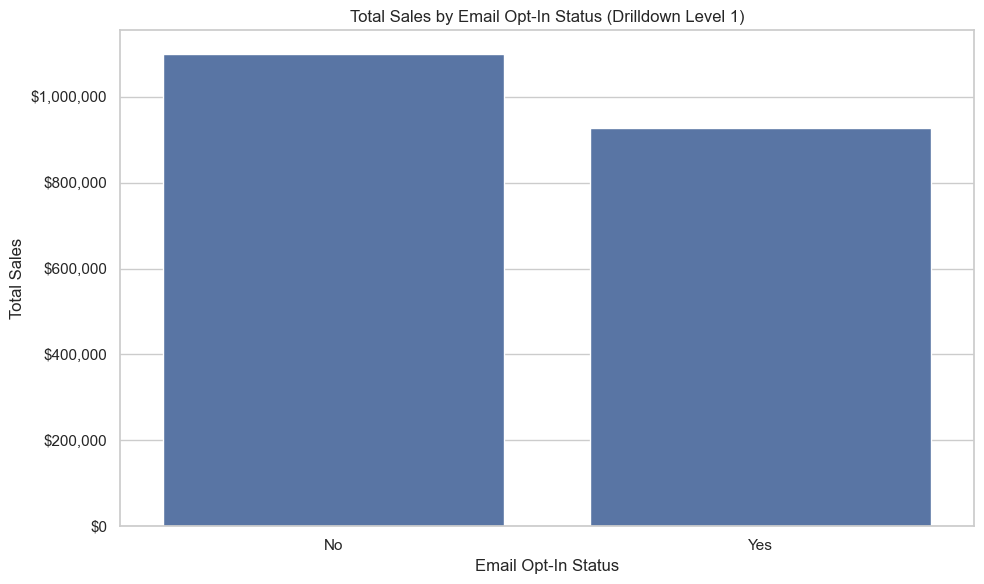

## Slice — Total Sales by Email Opt-In Status

Total sales from customers who did not opt in to marketing emails (“No”) were higher than those from email opt-in customers (“Yes”). The non-opt-in group generated more total revenue and constituted the larger share of purchasing activity.

---

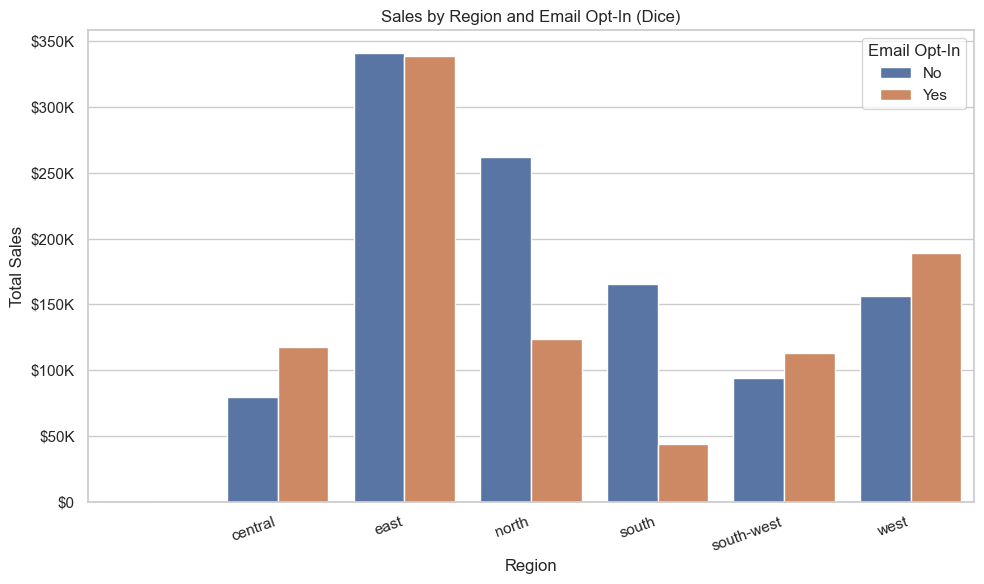

## Dice — Sales by Region and Email Opt-In

Regional splits showed that non-opt-in customers and opt-in customers each had three regions they were stronger in. Central, Southwest, and West were stronger for opt-in.  South, North and East were stronger for opt-out.  Of particular note is the South and North were much stronger for opt-out than opt-in.

---

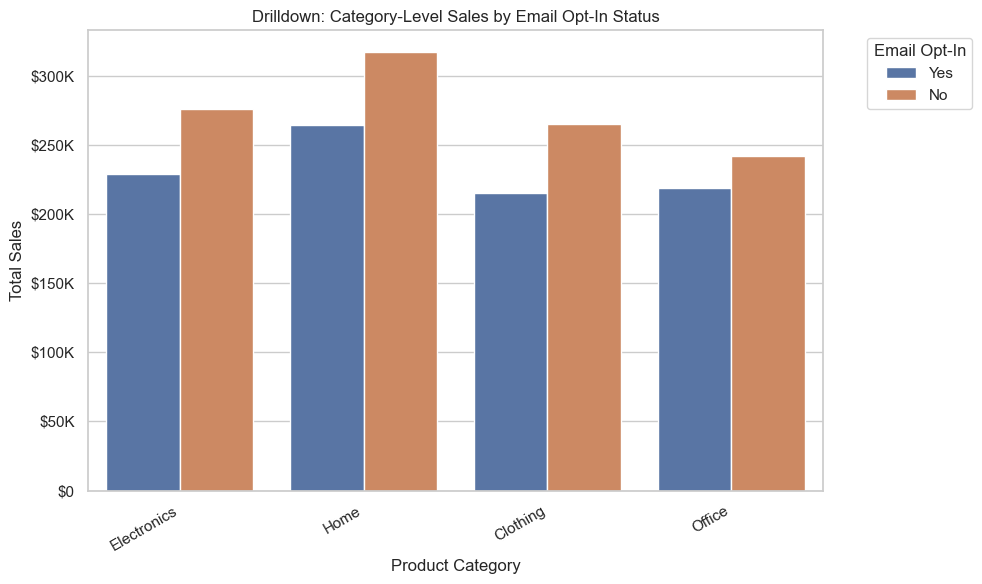

## Dice — Sales by Product Category and Email Opt-In

Across major categories (Clothing, Electronics, Home, Office), non-opt-in customers generated more total sales than opt-in customers in every category. The gap was largest in the Home category, though consistent across all.

---

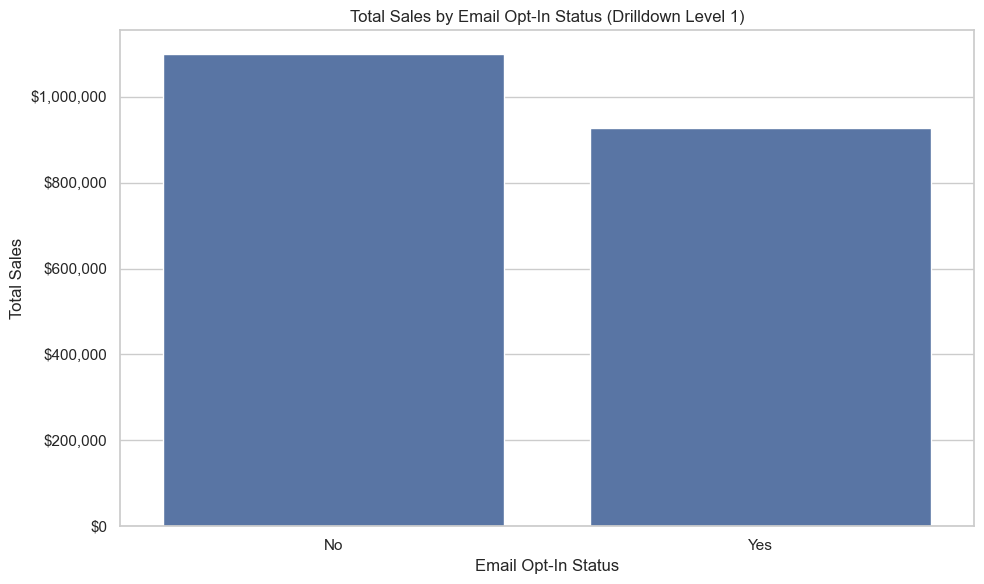

## Drilldown Level 1 — Category-Level Sales by Email Opt-In

Drilling down into category-level performance confirmed the same pattern: non-opt-in customers consistently generated higher sales in each category. Email opt-in customers did not lead in any category.

---

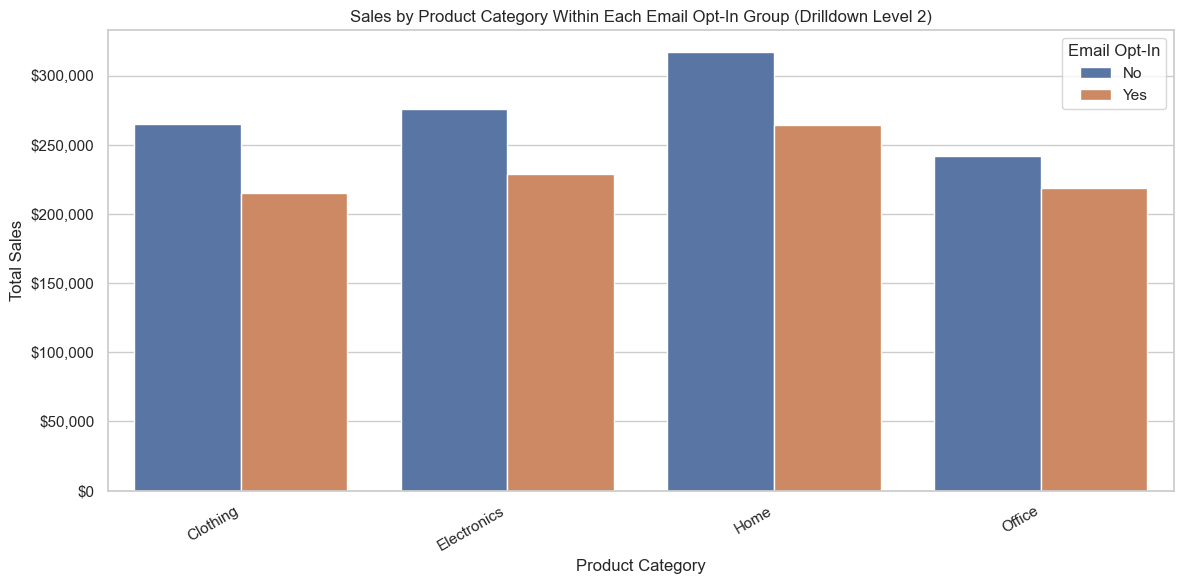

## Drilldown Level 2 — Product Category Within Each Opt-In Group

Examining the category mix within each opt-in group further reinforced this pattern. Non-opt-in customers purchased more in every category relative to opt-in customers.

---

## Distribution — Order Values by Email Opt-In

Order value distributions for both groups were similar, with no strong evidence that opt-in customers spend more per order. Median purchase amounts and ranges were nearly identical.

---

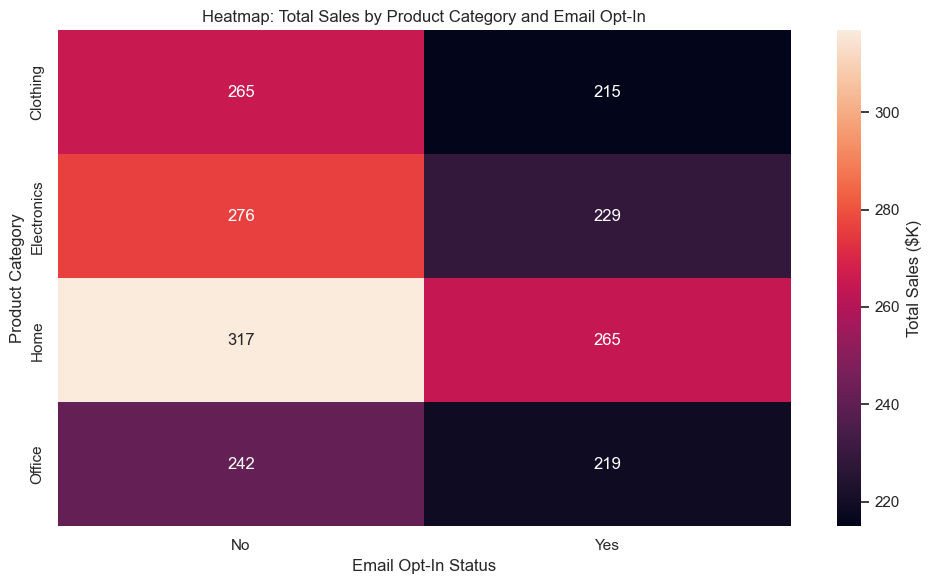
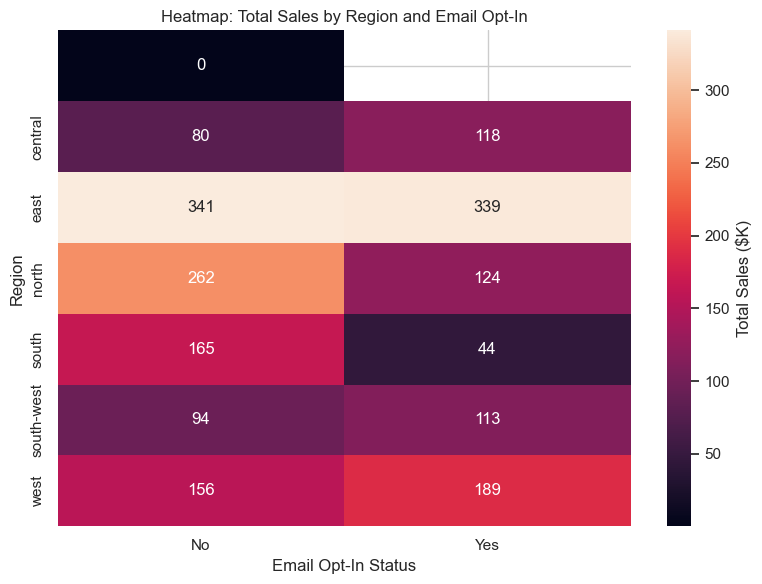

## Heatmaps — Category × Email Opt-In; Region × Email Opt-In

All heatmaps showed that revenue patterns were driven by a combination of geography and product mix. However, in heatmaps comparing email opt-in status, the non-opt-in group, with a few exceptions, generated the most revenue.

---

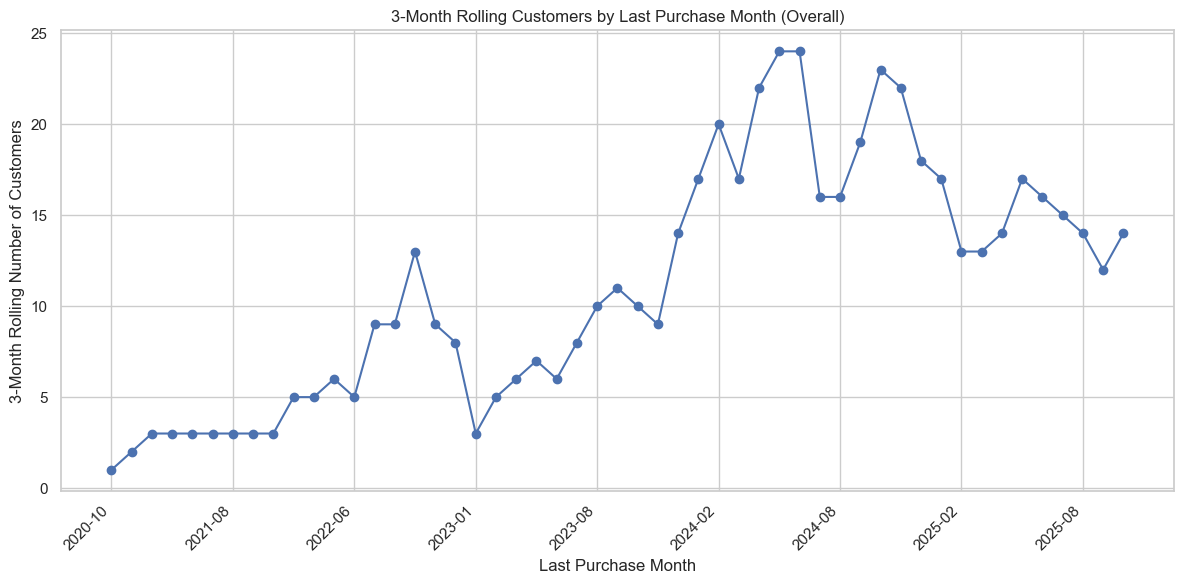

## 3-Month Rolling Trend — All Customers

The rolling monthly trend illustrated seasonal behavior with rising activity in the mid-year months and a subsequent decline. Smoothing clarified the timing of peak and low engagement periods.

---

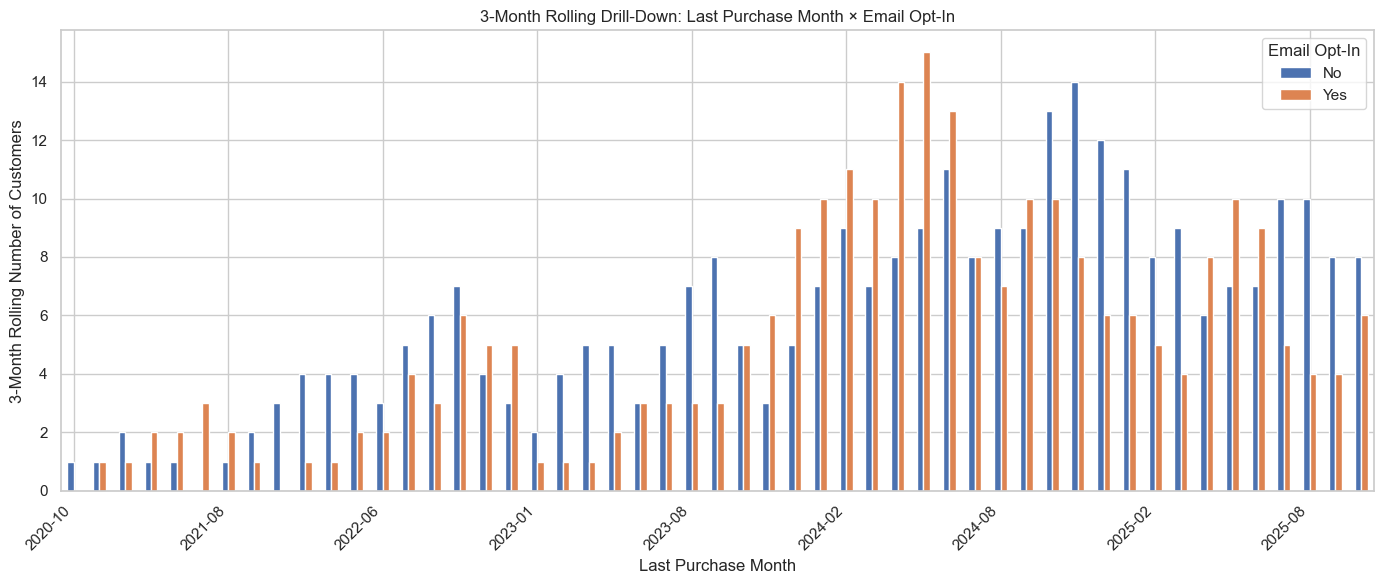

## 3-Month Rolling Drilldown — Email Opt-In Over Time

The rolling drilldown revealed that non-opt-in customers consistently maintained higher activity over time. Even with smoothing, the gap between opt-in and non-opt-in customers remained steady, indicating a persistent behavioral difference rather than random fluctuation.

---

## Overall Finding

Across all slices, dice operations, categories, regions, and time-based analyses, non-opt-in customers were the primary contributors to revenue and activity. Email opt-in status did not correlate with higher engagement, stronger transaction values, or increased purchasing activity.


⸻

# 6. Suggested Business Action

Based on the findings, several actions are recommended to improve decision-making and capitalize on observed patterns:

A. The email marketing approach should be reevaluated. Since opt-in customers did not demonstrate higher activity, the current email content, segmentation, send frequency, or list hygiene may not be effective. Small, controlled tests should be used to measure whether adjustments improve engagement.

B. Non–opt-in customers represent the largest source of revenue and should receive more attention. Alternative engagement channels such as SMS, push notifications, loyalty program messaging, or in-app communication may be more appropriate to reach this group.  However, care should be taken as to not be too aggressive as their non-opt-in status for emails may reflect a desire for minimal engagement.  Other forms of engagement should also be opt-in with perhaps encouragement to opt-in (i.e. immediate discount on a purchase).

C. Marketing efforts should prioritize high-performing regions and categories. Regions such as the east and west, along with categories like Electronics and Home, offer opportunities for targeted promotions and inventory optimization. Region-category combinations with strong historical performance should be emphasized.

D. To support ongoing analysis, materialized OLAP aggregates should be created for combinations such as month × email opt-in, region × category, category × opt-in, and rolling-window metrics. This will ensure faster dashboard performance and consistent reporting across teams.

E. Any future email marketing experiments should begin with small, measurable tests to determine whether specific types of messaging or category-focused promotions can increase opt-in engagement. Findings should be validated before scaling up campaign efforts.

## 7. Challenges

During the project, several challenges arose that required additional troubleshooting and cleanup before the analysis could move forward. One of the primary issues was data quality. Some fields contained malformed dates, placeholder values such as “?” or empty strings, and customer IDs that did not match any records in the customers table. These issues caused errors during timestamp conversion and produced inaccurate aggregations until they were identified and filtered out.  I've learned I need to get better at the cleaning part.  While I've identified ways to show data is incomplete or missing, it seems to consistently cause issues downstream.  I think with more practice I will get better at properly identifying missing or incomplete errors so it doesn't cause any parsing errors or odd looking charts with "stray" data.  

Another challenge involved inconsistent formatting of the email opt-in field. Early in the process, values appeared as 0/1, “Yes”/“No”, and in some cases null. Standardizing these values ensured that slicing, dicing, and drilldown comparisons were accurate and visually consistent across visualizations.  I could've (should've?) fixed this in the cleaning.  Changing 1, 0 to yes, no is easy to do once there instead of each time here. 

Time-based charts also presented difficulties due to dense monthly labels and uneven purchase activity. The initial month-by-month trend was cluttered and hard to interpret. Switching to a three-month rolling view improved readability and provided a clearer picture of customer behavior over time.

Finally, some visualizations required adjustment to achieve consistent scaling and layout, especially when placing multiple charts together in the notebook. These refinements ensured that the final presentation was clean, readable, and aligned with the project requirements.